# Libraries

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import seaborn as sns

# Data

In [105]:
df =  pd.read_csv('Data/data_customers.csv')
df.head()

,fullVisitorId,channelGrouping,weekend_prop,hour,sessionId,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,totals.hits,totals.pageviews,bounce_prop,trafficSource.medium
0,213131142648941,Direct,0.000000,22.0,1,Chrome,desktop,0.0,Macintosh,14.0,13.0,0.0,(none)
1,435324061339869,Referral,0.666667,21.0,3,Chrome,desktop,0.0,Macintosh,14.0,11.0,0.0,referral
2,562678147042735,Organic Search,0.000000,14.0,2,Chrome,desktop,0.0,Macintosh,12.5,10.5,0.0,organic
3,585708896049892,Referral,0.000000,20.0,1,Chrome,desktop,0.0,Linux,22.0,20.0,0.0,referral
4,670722016498267,Referral,0.000000,17.0,2,Chrome,desktop,0.0,Linux,9.5,9.5,0.0,referral


# EDA

## Datos Faltantes (missings)

In [8]:
df.isnull().sum() # en el siguiente output vemos que no hay missings

fullVisitorId             0
channelGrouping           0
weekend_prop              0
hour                      0
sessionId                 0
device.browser            0
device.deviceCategory     0
device.isMobile           0
device.operatingSystem    0
totals.hits               0
totals.pageviews          0
bounce_prop               0
trafficSource.medium      0
dtype: int64

## Análisis de columnas IDentificador

* La columna "fullVisitorId" es el identificador único del visitante: ¿Se repite el ID en la base de datos?
    * Respuesta: No, y lo demuestra la siguiente línea de código
    * Lo anterior es bueno porque muestra que un visitante tiene un ID único
    * Aunque también es bueno notar que un mismo usuario podría ser identificado cómo un usuario distinto, si este cambia de dispositivo

In [11]:
df["fullVisitorId"].value_counts(ascending=False)

fullVisitorId
9998996003043230595    1
213131142648941        1
435324061339869        1
562678147042735        1
585708896049892        1
                      ..
3961110741104601       1
3717831825503026       1
3450834640354121       1
3438471796886087       1
3038010493412298       1
Name: count, Length: 9996, dtype: int64

* La columna "sessionId" es el identificador de la sesión: ¿Se repite el ID en la base de datos?
    * Respuesta: Sí se repite el sessionId para distintos fullVisitorId
    * Alerta: una misma sesión fue asignada a distintos visitantes lo que podría deberse a que:
        * La misma sesión la pueden usar multiples personas en multiples dispositivos, pero esto representa un error en los datos
        * Lo común es que una sola persona (fullVisitorId) pueda tener múltiples sesiones (sessionId)
    * A continuación se muestra como la sessionId=1 fue operada por múltiples visitantes

In [13]:
df[df["sessionId"] == 1]

,fullVisitorId,channelGrouping,weekend_prop,hour,sessionId,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,totals.hits,totals.pageviews,bounce_prop,trafficSource.medium
0,213131142648941,Direct,0.0,22.0,1,Chrome,desktop,0.0,Macintosh,14.0,13.0,0.0,(none)
3,585708896049892,Referral,0.0,20.0,1,Chrome,desktop,0.0,Linux,22.0,20.0,0.0,referral
5,852801263780322,Direct,0.0,20.0,1,Chrome,desktop,0.0,Linux,28.0,22.0,0.0,(none)
6,1123528056036404,Direct,0.0,15.0,1,Chrome,desktop,0.0,Windows,35.0,31.0,0.0,(none)
8,2527528149176601,Organic Search,0.0,12.0,1,Safari,mobile,1.0,iOS,15.0,13.0,0.0,organic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,9990797196896345494,Organic Search,0.0,13.0,1,Chrome,desktop,0.0,Linux,40.0,26.0,0.0,organic
9991,9991633376050115277,Social,0.0,0.0,1,Chrome,desktop,0.0,Linux,17.0,16.0,0.0,referral
9993,9997409246962677759,Referral,0.0,2.0,1,Chrome,desktop,0.0,Macintosh,86.0,65.0,0.0,referral
9994,9998597322098588317,Direct,0.0,21.0,1,Chrome,desktop,0.0,Macintosh,37.0,33.0,0.0,(none)


## Detección de Datos Anómalos (Categóricos y Numéricos)

* Categorical Data: en la siguiente línea concluimos que no hay datos anómalos en los datos categóricos

In [23]:
for col in ['channelGrouping','device.browser', 'device.deviceCategory','device.operatingSystem', 'trafficSource.medium']:
   print(df[col].value_counts())

channelGrouping
Referral          4286
Organic Search    3233
Direct            1850
Paid Search        400
Display            141
Social              74
Affiliates          11
(Other)              1
Name: count, dtype: int64
device.browser
Chrome               8937
Safari                727
Firefox               161
Internet Explorer      95
Edge                   52
Safari (in-app)        12
Android Webview         6
Opera                   5
Amazon Silk             1
Name: count, dtype: int64
device.deviceCategory
desktop    9027
mobile      809
tablet      160
Name: count, dtype: int64
device.operatingSystem
Macintosh        5551
Windows          1991
Chrome OS         768
Linux             732
iOS               519
Android           434
Windows Phone       1
Name: count, dtype: int64
trafficSource.medium
referral     4365
organic      3158
(none)       1848
cpc           475
cpm           138
affiliate      11
(not set)       1
Name: count, dtype: int64


* Numeric Data: corriendo el siguiente código y visualizando cada columna, se visualizaron 4 columnas con datos anómalos:
    * device.isMobile: se encontraron valores distintos de 1 y 0, lo que no es correcto
    * totals.hits: se detectaron outliers
    * totals.pageviews: se detectaron outliers
    * bounce_prop: se detectaron outliers

In [25]:
for col in ['weekend_prop','hour', 'device.isMobile','totals.hits','totals.pageviews','bounce_prop']:
   print(df[col].describe())
   

count    9996.000000
mean        0.147011
std         0.296219
min         0.000000
25%         0.000000
50%         0.000000
75%         0.126359
max         1.000000
Name: weekend_prop, dtype: float64
count    9996.000000
mean       14.449030
std         6.261204
min         0.000000
25%        11.000000
50%        16.500000
75%        19.000000
max        23.000000
Name: hour, dtype: float64
count    9996.000000
mean        0.096870
std         0.295655
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: device.isMobile, dtype: float64
count    9996.000000
mean       22.177771
std        21.916773
min         1.000000
25%         9.000000
50%        17.000000
75%        28.000000
max       500.000000
Name: totals.hits, dtype: float64
count    9996.000000
mean       17.530312
std        16.259149
min         1.000000
25%         8.000000
50%        14.000000
75%        22.500000
max       466.000000
Name: totals.pageviews, dt

# Pre-procesamiento: tratamiento de anomalías

## Tratamiento de outliers

* Columna  totals.hits
    * podemos ver que el 99% de los datos es menor a 101
    * Y que el 1% representa a 97 visitantes
    * Dado que el número de visitantes con alto número de interacciones (hits) puede incrementar, No eliminaremos Outliers
    * Lo que sí haremos es estandarizar la columna


In [47]:
print('¿Cómo se ve la distribución?: ' + '\n')
print(df['totals.hits'].describe(percentiles=[0.25,0.5, 0.75,0.95,0.99]))
print('\n')
print('¿Cuántos visitantes representan el 1%?:' )
print(df[df['totals.hits'] > 101].shape[0])

¿Cómo se ve la distribución?: 

count    9996.000000
mean       22.177771
std        21.916773
min         1.000000
25%         9.000000
50%        17.000000
75%        28.000000
95%        59.625000
99%       101.000000
max       500.000000
Name: totals.hits, dtype: float64


¿Cuántos visitantes representan el 1%?:
97


In [60]:
# Estandarizamos la columna
# Transformación logarítmica

df['totals.hits.log'] = np.log(df['totals.hits'])

* Columna  totals.pageviews
    * podemos ver que el 99% de los datos es menor a 71
    * Y que el 1% representa a 100 visitantes
    * Dado que el número de páginas vistas por visitante puede incrementar en el futuro, No eliminaremos Outliers
    * Lo que sí haremos es estandarizar la columna

In [49]:
print('¿Cómo se ve la distribución?: ' + '\n')
print(df['totals.pageviews'].describe(percentiles=[0.25,0.5, 0.75,0.95,0.99]))
print('\n')
print('¿Cuántos visitantes representan el 1%?:' )
print(df[df['totals.pageviews'] > 71].shape[0])

¿Cómo se ve la distribución?: 

count    9996.000000
mean       17.530312
std        16.259149
min         1.000000
25%         8.000000
50%        14.000000
75%        22.500000
95%        44.500000
99%        71.050000
max       466.000000
Name: totals.pageviews, dtype: float64


¿Cuántos visitantes representan el 1%?:
100


In [61]:
# Estandarizamos la columna
# Transformación logarítmica

df['totals.pageviews.log'] = np.log(df['totals.pageviews'])

* Columna  bounce_prop
    * podemos ver que el 99% de los datos es menor a 71
    * Y que el 1% representa a 43 visitantes
    * Dado que ha habido varios visitantes que han presentado un alto indice de rebotes, conservaremos los datos, pues aunque sean anómalos nos pueden hablar de un problema con la plataforma en algún punto del tiempo
    * Esta columna ya está estandarizada de 0 a 1

In [53]:
print('¿Cómo se ve la distribución?: ' + '\n')
print(df['bounce_prop'].describe(percentiles=[0.25,0.5, 0.75,0.95,0.99]))
print('\n')
print('¿Cuántos visitantes representan el 1%?:' )
print(df[df['bounce_prop'] >= 0.67].shape[0])

¿Cómo se ve la distribución?: 

count    9996.000000
mean        0.082718
std         0.162298
min         0.000000
25%         0.000000
50%         0.000000
75%         0.083333
95%         0.500000
99%         0.666667
max         0.925373
Name: bounce_prop, dtype: float64


¿Cuántos visitantes representan el 1%?:
43


## Correción de categorías

* La columnna device.isMobile presentó valores distintos de 1 y 0, lo que no es correcto, vamos a corregirlo tomando en cuenta la información que se encuentra en la columna device.deviceCategory
* para asegurarnos de que  device.isMobile sea correctamente etiquetado en todos los casos, haremos lo siguiente: todos las etiquetas 'desktop' serán un '0' en device.isMobile, y todas las etiquetas 'mobile y tablet' serán '1' en device.isMobile

In [56]:
df['device.isMobile'] = df['device.deviceCategory'].map(lambda x: 0 if x == 'desktop' else 1)
print(df['device.isMobile'].value_counts())
print(df['device.deviceCategory'].value_counts() )

# al final vemos que la suma de mobile+tablet = 969

device.isMobile
0    9027
1     969
Name: count, dtype: int64
device.deviceCategory
desktop    9027
mobile      809
tablet      160
Name: count, dtype: int64


# Selección de Variables

* Ahora seleccionaremos todas las columnas menos las de ID (sessionId y fullVisitorId)

In [63]:
df_selected = df[['channelGrouping','device.browser', 'device.deviceCategory','device.operatingSystem', 'trafficSource.medium',
                  'device.isMobile','weekend_prop','hour','totals.hits.log','totals.pageviews.log','bounce_prop']].copy()

df_selected.head()

,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,trafficSource.medium,device.isMobile,weekend_prop,hour,totals.hits.log,totals.pageviews.log,bounce_prop
0,Direct,Chrome,desktop,Macintosh,(none),0,0.000000,22.0,2.639057,2.564949,0.0
1,Referral,Chrome,desktop,Macintosh,referral,0,0.666667,21.0,2.639057,2.397895,0.0
2,Organic Search,Chrome,desktop,Macintosh,organic,0,0.000000,14.0,2.525729,2.351375,0.0
3,Referral,Chrome,desktop,Linux,referral,0,0.000000,20.0,3.091042,2.995732,0.0
4,Referral,Chrome,desktop,Linux,referral,0,0.000000,17.0,2.251292,2.251292,0.0


* Hasta aquí guardaremos una Copia de Seguridad, esto nos ahorra tiempo

In [64]:
df_selected.to_csv('Data/df_selected.csv')

In [7]:
df_selected = pd.read_csv('Data/df_selected.csv')

In [8]:
df_selected.drop(columns=['Unnamed: 0'],inplace=True)

# Pre-procesamiento: transformación de variables categóricas

In [9]:
columnas_categoricas = ['channelGrouping','device.browser', 'device.deviceCategory','device.operatingSystem', 'trafficSource.medium']
df_all_numeric = pd.get_dummies(df_selected, columns=columnas_categoricas)

In [10]:
df_all_numeric.columns

Index(['device.isMobile', 'weekend_prop', 'hour', 'totals.hits.log',
       'totals.pageviews.log', 'bounce_prop', 'channelGrouping_(Other)',
       'channelGrouping_Affiliates', 'channelGrouping_Direct',
       'channelGrouping_Display', 'channelGrouping_Organic Search',
       'channelGrouping_Paid Search', 'channelGrouping_Referral',
       'channelGrouping_Social', 'device.browser_Amazon Silk',
       'device.browser_Android Webview', 'device.browser_Chrome',
       'device.browser_Edge', 'device.browser_Firefox',
       'device.browser_Internet Explorer', 'device.browser_Opera',
       'device.browser_Safari', 'device.browser_Safari (in-app)',
       'device.deviceCategory_desktop', 'device.deviceCategory_mobile',
       'device.deviceCategory_tablet', 'device.operatingSystem_Android',
       'device.operatingSystem_Chrome OS', 'device.operatingSystem_Linux',
       'device.operatingSystem_Macintosh', 'device.operatingSystem_Windows',
       'device.operatingSystem_Windows Phone',

# Segmentación de clientes: modelos de Clustering

* Probaremos 2 modelos de clustering:
    * DBSCAN
    * K-means
* Utilizaremos cómo métricas para evaluar la calidad de clustering:
    * Silhoutte-Score
        * -1 ≤ Silhouette Score ≤ 1
        *  1: Clusters bien definidos y separados (óptimo).
        *  0: Clusters superpuestos (regular).
        * -1: Muy malos clusters (puntos mal asignados).
    * Índice Calinski-Harabasz: Mide la relación entre la varianza entre clusters (BWC) y la varianza dentro de clusters (WCV)
        * Valor alto: Clusters bien definidos y separados
        * Valor bajo: Clusters superpuestos o mal definidos


In [11]:
# Pasamos el dataframe a un Array
X =  df_all_numeric.values
X

array([[0, 0.0, 22.0, ..., False, False, False],
       [0, 0.6666666666666666, 21.0, ..., False, False, True],
       [0, 0.0, 14.0, ..., False, True, False],
       ...,
       [0, 0.0, 2.0, ..., False, False, True],
       [0, 0.0, 21.0, ..., False, False, False],
       [0, 0.0, 5.0, ..., False, True, False]], dtype=object)

* DBSCAN: en general no se encontró un buen reconocimiento de clusters con DBSCAN a pesar de hacer tuneo de hiperparámetros (ebs y min_samples)

In [60]:
# DBSCAN
radius = [0.5,0.6,0.7,0.8]
points = [20,50,80]
for valr in radius:
    for valp in points:
        # Parámetros DBSCAN
        eps = valr          # Radio de vecindad que es la distancia máxima entre puntos para considerarlos vecinos.
        min_samples = valp        # Mínimo de puntos para formar cluster
        metric = "euclidean"    # Métrica de distancia (por defecto: euclidiana)

        # Crear objeto DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples,metric=metric)

        # Ajustar modelo
        db.fit(X)

        # Obtener etiquetas de cluster
        etiquetas = db.labels_

        # Calcular Silhouette Score
        silhouette = silhouette_score(X, etiquetas)
        # Calcular CHS
        chs = calinski_harabasz_score(X, etiquetas)

        print(f"Métricas de rendimiento para eps:{valr} y min_samples:{valp} : ")
        print("Silhouette Score:", silhouette)
        print("Índice Calinski-Harabasz:", chs)
        print("\n")

Métricas de rendimiento para eps:0.5 y min_samples:20 : 
Silhouette Score: -0.5124749953378558
Índice Calinski-Harabasz: 59.622302412807535


Métricas de rendimiento para eps:0.5 y min_samples:50 : 
Silhouette Score: -0.39792310414136534
Índice Calinski-Harabasz: 57.72266953703384


Métricas de rendimiento para eps:0.5 y min_samples:80 : 
Silhouette Score: -0.3205431148739782
Índice Calinski-Harabasz: 31.96015249505142


Métricas de rendimiento para eps:0.6 y min_samples:20 : 
Silhouette Score: -0.36186330268084166
Índice Calinski-Harabasz: 262.785520165068


Métricas de rendimiento para eps:0.6 y min_samples:50 : 
Silhouette Score: -0.09064135095461463
Índice Calinski-Harabasz: 696.954705098941


Métricas de rendimiento para eps:0.6 y min_samples:80 : 
Silhouette Score: -0.15346576874153825
Índice Calinski-Harabasz: 423.49595641009705


Métricas de rendimiento para eps:0.7 y min_samples:20 : 
Silhouette Score: -0.46744804338239887
Índice Calinski-Harabasz: 200.27169764699386


Métrica

* KMeans: encontramos clusters con características similares, tuvimos una mejor agrupación con respecto a DBSCAN

In [ ]:
# Método del codo para K-means
# Calcular inercia para diferentes K
inercias = []
for k in range(1, 11):
 kmeans = KMeans(n_clusters=k)
 kmeans.fit(X)
 inercias.append(kmeans.inertia_)

# Graficar
plt.plot(range(1, 11), inercias)
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia")
plt.title("Método del Codo")
plt.show()

In [39]:
# KMEANS
for i in [3,4,5]:
    kmeans = KMeans(n_clusters=i, random_state=143)
    kmeans.fit(X)
    etiquetas = kmeans.labels_

    # Calcular Silhouette Score
    silhouette = silhouette_score(X, etiquetas)
    # Calcular CHS
    chs = calinski_harabasz_score(X, etiquetas)

    print(f"Métricas de rendimiento para {i}-clusters: ")
    print("Silhouette Score:", silhouette)
    print("Índice Calinski-Harabasz:", chs)
    print("\n")


Métricas de rendimiento para 3-clusters: 
Silhouette Score: 0.4187116663607956
Índice Calinski-Harabasz: 20857.916515615427


Métricas de rendimiento para 4-clusters: 
Silhouette Score: 0.3416253537046619
Índice Calinski-Harabasz: 18925.372494438026


Métricas de rendimiento para 5-clusters: 
Silhouette Score: 0.2971623374704623
Índice Calinski-Harabasz: 16154.557335261565




* Modelo Finalista
    * K-means: 3 clusters

In [61]:
kmeans = KMeans(n_clusters=3, random_state=143)
kmeans.fit(X)
etiquetas = kmeans.labels_

* Reducción de dimensiones para graficar

In [ ]:
# Reduccion de dimensionalidad (útil para visualización en 2D)


# Normalizar datos para no vernos afectados por los valores grandes en la reducción de dimensión
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=143)
X_reducido = tsne.fit_transform(X_normalizado)

In [67]:
X_reducido

array([[  3.256794 ,   1.4158716],
       [-24.550879 , -39.209217 ],
       [-19.330837 ,  59.455727 ],
       ...,
       [-45.21816  ,   6.0316257],
       [ -1.4160421,  18.273302 ],
       [-12.118817 ,  70.88701  ]], dtype=float32)

In [71]:
etiquetas.max()

np.int32(2)

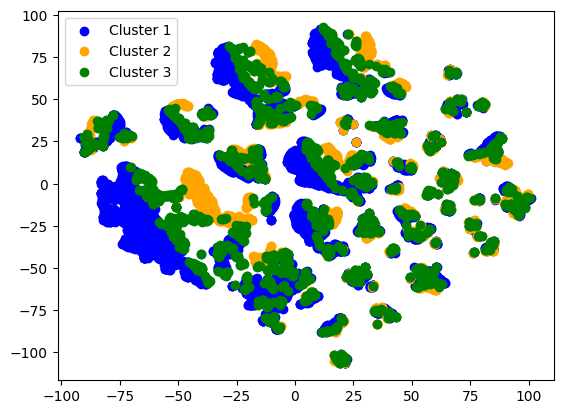

In [72]:
# Visualizar clusters
plt.scatter(X_reducido[etiquetas == 0, 0], X_reducido[etiquetas == 0, 1], c='blue', label='Cluster 1')
plt.scatter(X_reducido[etiquetas == 1, 0], X_reducido[etiquetas == 1, 1], c='orange', label='Cluster 2')
plt.scatter(X_reducido[etiquetas == 2, 0], X_reducido[etiquetas == 2, 1], c='green', label='Cluster 3')

plt.legend()
plt.show()

In [ ]:
# Reduccion de dimensionalidad (útil para visualización en 3D)


# Normalizar datos para no vernos afectados por los valores grandes en la reducción de dimensión
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

# Aplicar t-SNE
tsne = TSNE(n_components=3, random_state=143)
X_reducido = tsne.fit_transform(X_normalizado)

In [76]:
# Visualizar clusters
import plotly.graph_objects as go

# Gráfico 3D interactivo
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=X_reducido[etiquetas == 0, 0],
    y=X_reducido[etiquetas == 0, 1],
    z=X_reducido[etiquetas == 0, 2],
    mode='markers',
    marker=dict(color='blue'),
    name='Cluster 1'
))

fig.add_trace(go.Scatter3d(
    x=X_reducido[etiquetas == 1, 0],
    y=X_reducido[etiquetas == 1, 1],
    z=X_reducido[etiquetas == 1, 2],
    mode='markers',
    marker=dict(color='green'),
    name='Cluster 2'
))

fig.add_trace(go.Scatter3d(
    x=X_reducido[etiquetas == 2, 0],
    y=X_reducido[etiquetas == 2, 1],
    z=X_reducido[etiquetas == 2, 2],
    mode='markers',
    marker=dict(color='orange'),
    name='Cluster 3'
))

fig.update_layout(title='Clustering 3D', scene = dict(
                    xaxis_title='Eje X',
                    yaxis_title='Eje Y',
                    zaxis_title='Eje Z'))

fig.show()

# Segmentación de Clientes: Interpretación de resultados

* Partimos de que tenemos 3 grupos de clientes

In [84]:
df_selected['cluster'] = kmeans.labels_
df_selected.sample(10)

,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,trafficSource.medium,device.isMobile,weekend_prop,hour,totals.hits.log,totals.pageviews.log,bounce_prop,cluster
5469,Referral,Chrome,desktop,Macintosh,referral,0,0.0,19.5,2.564949,2.484907,0.0,0
3685,Referral,Chrome,desktop,Macintosh,referral,0,0.0,4.0,2.970414,2.833213,0.0,1
8770,Referral,Chrome,desktop,Macintosh,referral,0,0.0,0.0,2.197225,2.197225,0.0,1
7064,Referral,Chrome,desktop,Macintosh,referral,0,0.0,7.0,2.442347,2.197225,0.0,1
3428,Referral,Chrome,desktop,Macintosh,referral,0,0.0,5.0,3.367296,3.258097,0.0,1
787,Paid Search,Chrome,desktop,Windows,cpc,0,0.0,18.0,4.043051,3.871201,0.0,0
3166,Organic Search,Safari,desktop,Macintosh,organic,0,1.0,14.0,3.178054,3.044522,0.0,2
4107,Direct,Chrome,desktop,Windows,(none),0,1.0,3.0,3.526361,3.295837,0.0,1
1323,Referral,Chrome,desktop,Linux,referral,0,0.0,18.5,4.110874,3.784190,0.0,0
9751,Paid Search,Chrome,desktop,Windows,cpc,0,0.0,13.0,3.044522,2.772589,0.0,2


In [91]:
df_selected.cluster.value_counts(1)

cluster
0    0.575330
2    0.227391
1    0.197279
Name: proportion, dtype: float64

## Gráficos de barras

cluster             0    1    2
channelGrouping                
(Other)             1    0    0
Affiliates          4    3    4
Direct           1126  309  415
Display           102   10   29
Organic Search   1624  819  790
Paid Search       180  118  102
Referral         2674  694  918
Social             40   19   15


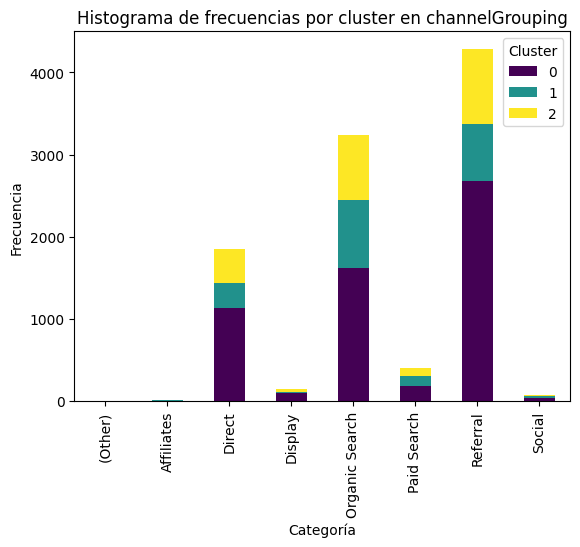

cluster               0     1     2
device.browser                     
Amazon Silk           0     0     1
Android Webview       1     4     1
Chrome             5262  1653  2022
Edge                 23    18    11
Firefox              88    33    40
Internet Explorer    55    20    20
Opera                 4     1     0
Safari              311   240   176
Safari (in-app)       7     3     2


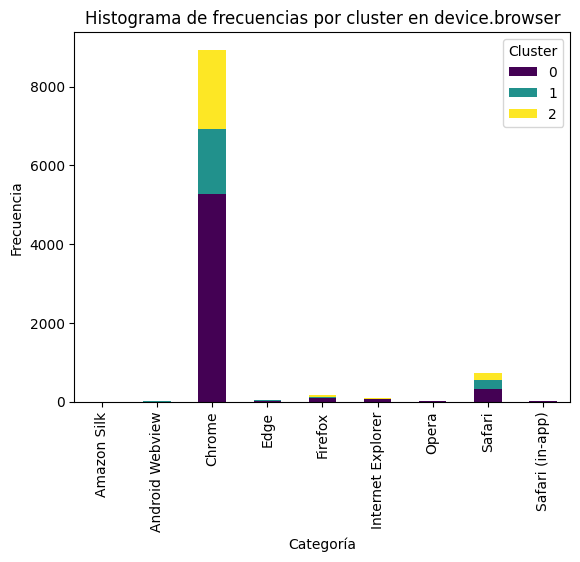

cluster                   0     1     2
device.deviceCategory                  
desktop                5356  1671  2000
mobile                  341   243   225
tablet                   54    58    48


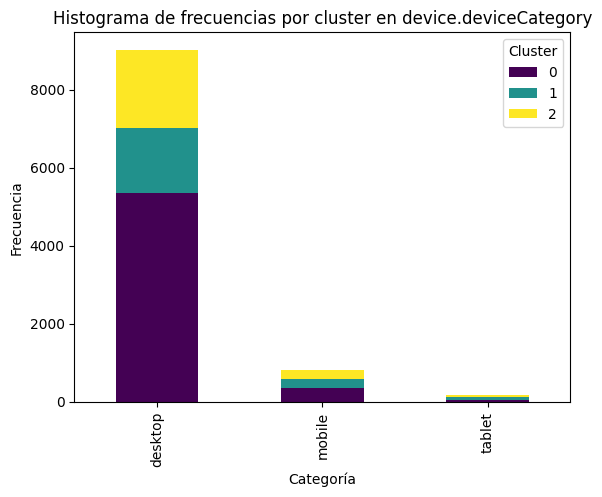

cluster                    0     1     2
device.operatingSystem                  
Android                  185   114   135
Chrome OS                406   171   191
Linux                    527    86   119
Macintosh               3324  1015  1212
Windows                 1108   404   479
Windows Phone              0     0     1
iOS                      201   182   136


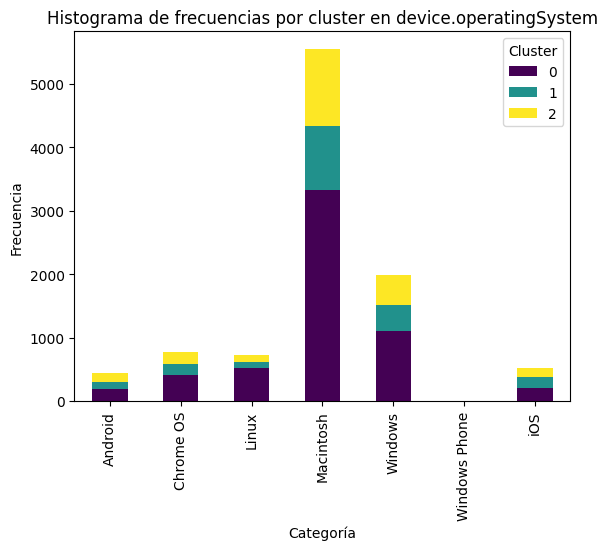

cluster                  0    1    2
trafficSource.medium                
(none)                1124  309  415
(not set)                1    0    0
affiliate                4    3    4
cpc                    216  145  114
cpm                    100    9   29
organic               1588  793  777
referral              2718  713  934


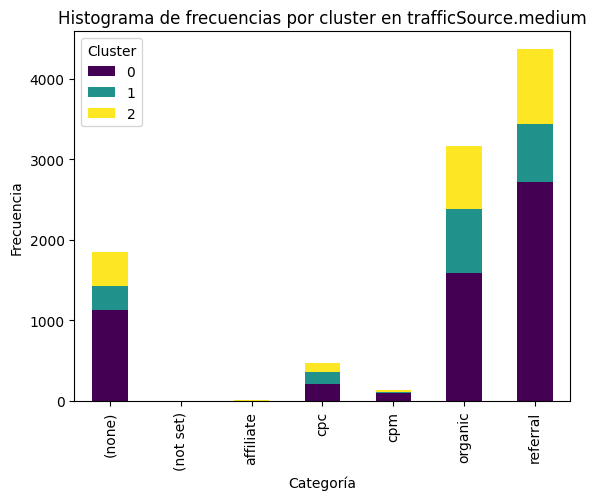

In [90]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo 'df_selected' es tu DataFrame
for val in columnas_categoricas:
    # Contar frecuencias por cluster
    frecuencias_cluster = df_selected.pivot_table(index=val, columns='cluster', aggfunc='size', fill_value=0)
    print(frecuencias_cluster)

    # Gráfico
    frecuencias_cluster.plot(kind='bar', stacked=True, colormap='viridis')
    plt.xlabel('Categoría')
    plt.ylabel('Frecuencia')
    plt.title(f'Histograma de frecuencias por cluster en {val}')
    plt.legend(title='Cluster')
    plt.show()

In [93]:
df_selected.columns

Index(['channelGrouping', 'device.browser', 'device.deviceCategory',
       'device.operatingSystem', 'trafficSource.medium', 'device.isMobile',
       'weekend_prop', 'hour', 'totals.hits.log', 'totals.pageviews.log',
       'bounce_prop', 'cluster'],
      dtype='object')

Media de weekend_prop en el cluster 0: 
0.11799535590546213


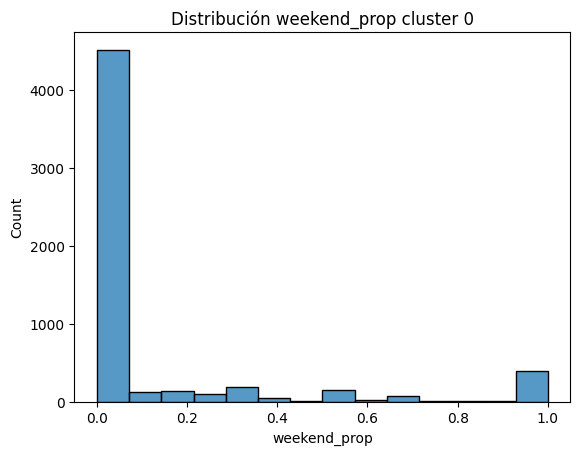

Media de weekend_prop en el cluster 1: 
0.2161817197243663


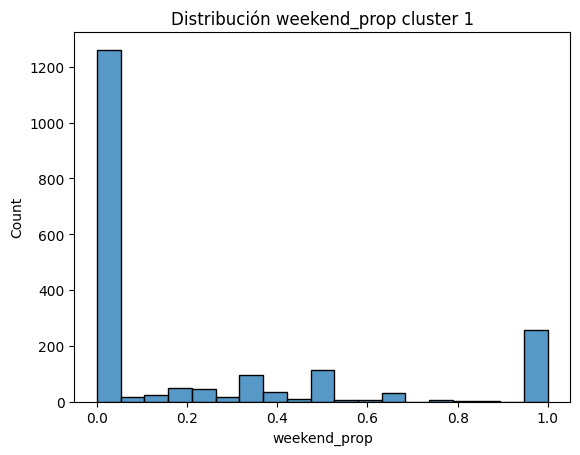

Media de weekend_prop en el cluster 2: 
0.1604133453508614


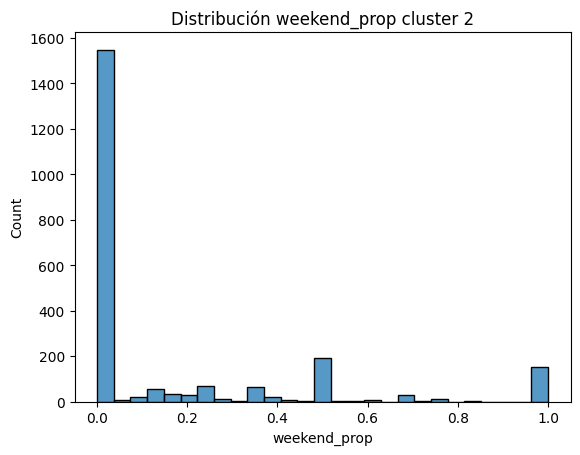

Media de hour en el cluster 0: 
18.77995131281516


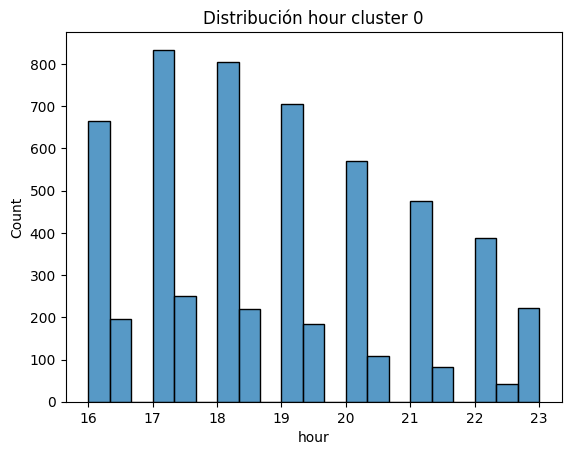

Media de hour en el cluster 1: 
3.5022819472616633


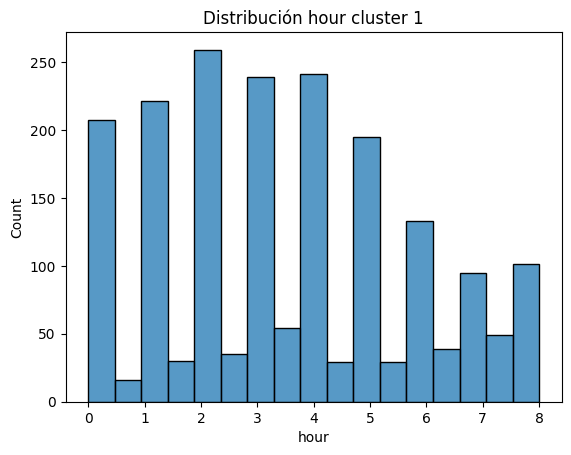

Media de hour en el cluster 2: 
12.988341399032116


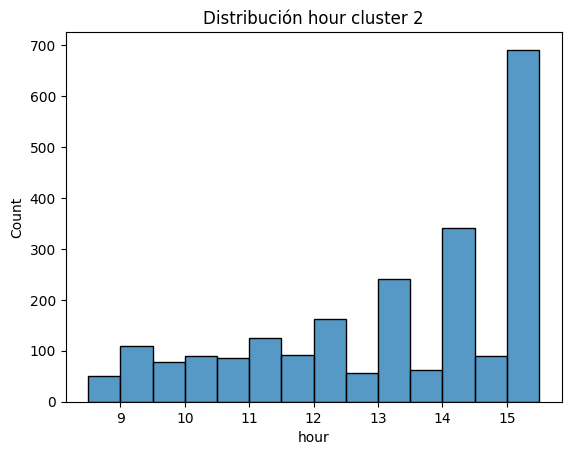

Media de bounce_prop en el cluster 0: 
0.08217271893142251


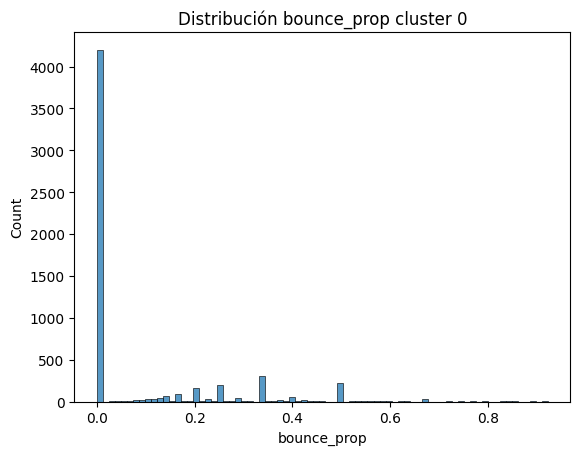

Media de bounce_prop en el cluster 1: 
0.06333204797914291


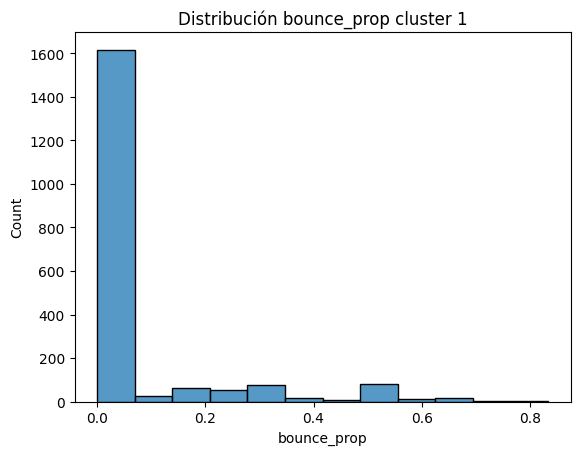

Media de bounce_prop en el cluster 2: 
0.10091695675461394


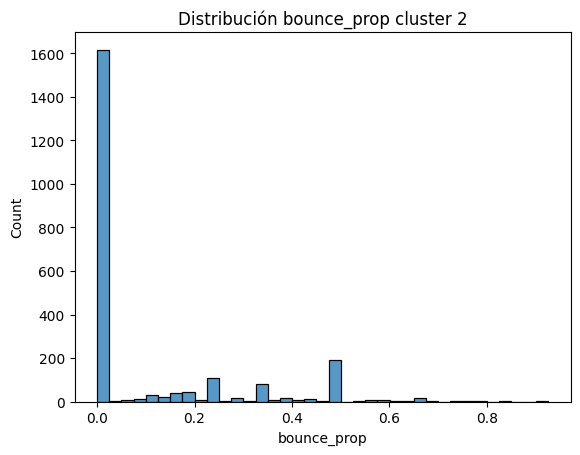

In [111]:
# Histograma
columnas_numericas = ['weekend_prop', 'hour','bounce_prop']
for val in columnas_numericas:
    for cluster_num in [0,1,2]:
        print(f'Media de {val} en el cluster {cluster_num}: ')
        print(df_selected[df_selected.cluster == cluster_num][val].mean())
        sns.histplot(df_selected[df_selected.cluster == cluster_num], x=val)
        plt.title(f'Distribución {val} cluster {cluster_num}')
        plt.show()

In [107]:
df['cluster'] = kmeans.labels_

In [109]:
df.columns

Index(['fullVisitorId', 'channelGrouping', 'weekend_prop', 'hour', 'sessionId',
       'device.browser', 'device.deviceCategory', 'device.isMobile',
       'device.operatingSystem', 'totals.hits', 'totals.pageviews',
       'bounce_prop', 'trafficSource.medium', 'cluster'],
      dtype='object')

Media de totals.hits en el cluster 0: 
20.724134933055122


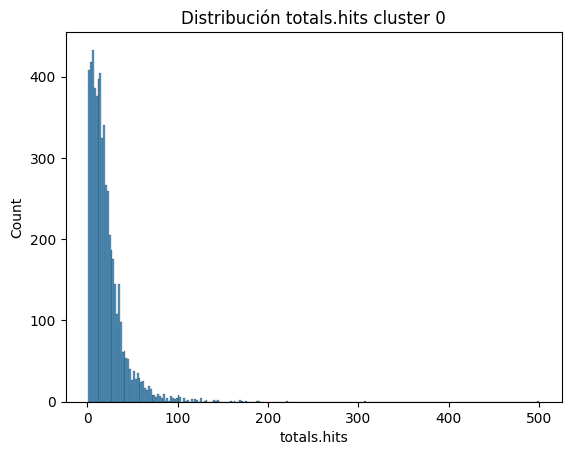

Media de totals.hits en el cluster 1: 
27.197008113590265


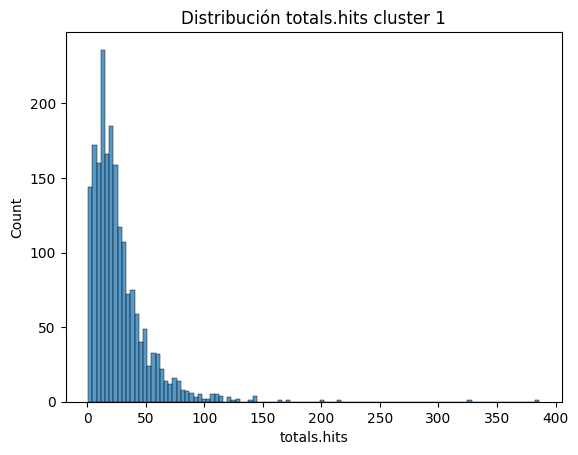

Media de totals.hits en el cluster 2: 
21.50109986801584


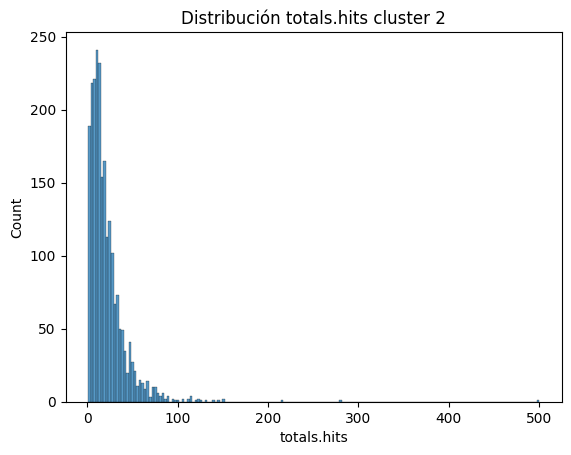

Media de totals.pageviews en el cluster 0: 
16.41923143801078


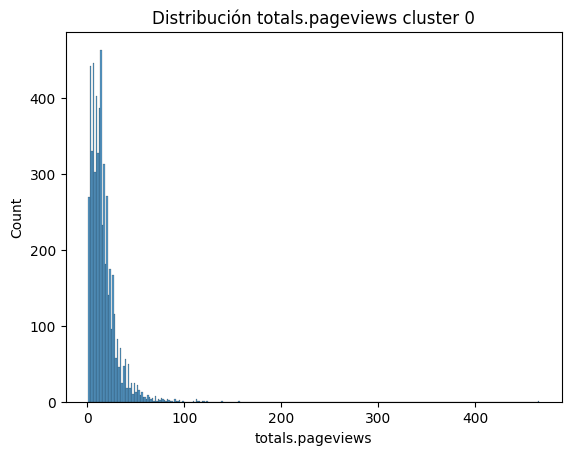

Media de totals.pageviews en el cluster 1: 
21.427991886409735


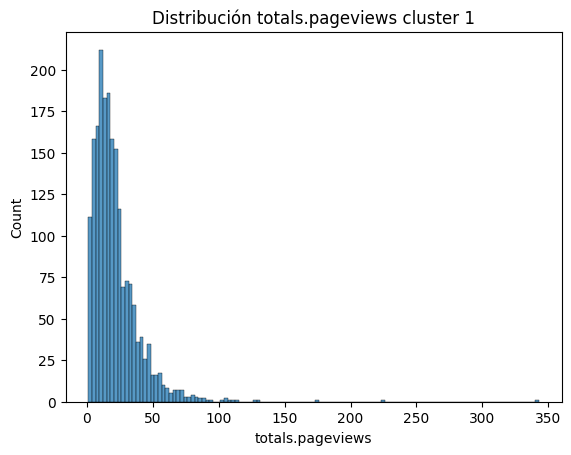

Media de totals.pageviews en el cluster 2: 
16.959964804223493


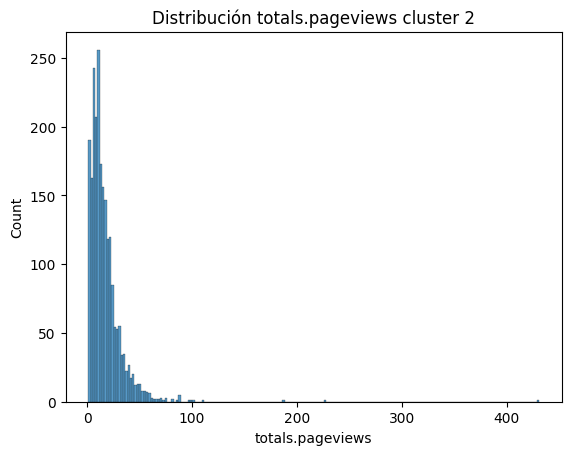

In [110]:
# utili
columnas_numericas = ['totals.hits', 'totals.pageviews']
for val in columnas_numericas:
    for cluster_num in [0,1,2]:
        print(f'Media de {val} en el cluster {cluster_num}: ')
        print(df[df.cluster == cluster_num][val].mean())
        sns.histplot(df[df.cluster == cluster_num], x=val)
        plt.title(f'Distribución {val} cluster {cluster_num}')
        plt.show()

## Interpretación

En general tenemos más clientes "Grupo 0" y menos del "Grupo 1"

* Caracteríticas de cada grupo:

    * Grupo 0:
        * Estos clientes acceden más por medio de sitios web de terceros (channelGrouping:Referral)
        * Estos clientes son los que menos entran los fines de semana (weekend_prop)
        * Estos clientes entran al sitio web en la tarde noche de 17:00 a 23:00 hrs (hour)
        * Estos clientes el navegador que más usan es Chrome (device.browser)
        * Estos clientes utilizan más desktop para acceder (device.deviceCategory)
        * Estos clientes utilizan más Macintosh (device.operatingSystem)
        * Estos clientes utilizan dispositivos no considerados como moviles (device.isMobile)
        * Estos clientes tienen menos interacciones al estar en el sitio (totals.hits)(20)
        * Estos clientes ven menos páginas en la sesión (totals.pageviews)(16)
        * Estos clientes han tenido un menor índice de rebotes (bounce_prop)
        * Estos clientes ingresan más por las alianzas con sitios de terceros  (referral) y no tanto por Ads (trafficSource.medium)
    * Grupo 1:
        * Estos clientes (channelGrouping:Referral)
        * Estos clientes si entran más los fines de semana con respecto a los otros grupos (weekend_prop)
        * Estos clientes entran en la madrugada o en la mañana entre 00:00 y 8:00 (hour)
        * Estos clientes el navegador que más usan es Chrome (device.browser)
        * Estos clientes utilizan más desktop para acceder (device.deviceCategory)
        * Estos clientes utilizan más Macintosh y son los que utilizan menos Linux respecto de otros grupos (device.operatingSystem)
        * Estos clientes utilizan dispositivos no considerados como moviles (device.isMobile)
        * Estos clientes tienen mas interacciones al estar en el sitio (totals.hits)(27)
        * Estos clientes ven más páginas en la sesión (totals.pageviews)(21)
        * Estos clientes son los que menos rebotes han tenido (bounce_prop)
        * Estos clientes mayormente entran por las alianzas con sitios de terceros (referral) o buscando directo el sitio (organic) y son los que menos entran por anuncios(cpm) (trafficSource.medium)
    * Grupo 2:
        * Estos clientes (channelGrouping:Referral)
        * Estos clientes entran pocas veces los fines de semana pero más vecese que el grupo 0 (weekend_prop)
        * Estos clientes entran en la mañana y temprano por la tarde de 8:00 a 15:00 hrs (hour)
        * Estos clientes el navegador que más usan es Chrome (device.browser)
        * Estos clientes utilizan más desktop para acceder (device.deviceCategory)
        * Estos clientes utilizan más Macintosh y son los que utilizan menos iOS respecto de otros grupos(device.operatingSystem)
        * Estos clientes utilizan dispositivos no considerados como moviles (device.isMobile)
        * Estos clientes tienen menos interacciones al estar en el sitio (totals.hits)(21)
        * Estos clientes ven menos páginas en la sesión (totals.pageviews)(17)
        * Estos clientes son los que más rebotes han tenido (bounce_prop)
        * Estos clientes ingresan más por las alianzas con sitios de terceros  (referral) y no tanto por Ads (trafficSource.medium)


In [103]:
df_selected.cluster.value_counts()

cluster
0    5751
2    2273
1    1972
Name: count, dtype: int64

In [ ]:
## Recomendaciones